In [1]:
import jax.numpy as jnp
import jax
import numpy as np

import src.models
import orbax.checkpoint
from src.training import utils

In [2]:
# from experiments.ou import train_score_fixed_endpt
# 
# times = np.arange(12, 16)
# key = jax.random.PRNGKey(1)
# for time in times:
#     train_score_fixed_endpt.main(key, T=time)

Training


Epoch: 0, Loss: 19642228.0
Epoch: 1, Loss: 405396.09375
Epoch: 2, Loss: 30903.921875
Epoch: 3, Loss: 8939.4208984375
Epoch: 4, Loss: 1527.8187255859375
Epoch: 5, Loss: 656.5147705078125
Epoch: 6, Loss: 307.2508544921875
Epoch: 7, Loss: 76.50212097167969
Epoch: 8, Loss: 34.121734619140625
Epoch: 9, Loss: 13.165739059448242
Epoch: 10, Loss: 5.441088676452637
Epoch: 11, Loss: 2.419743299484253
Epoch: 12, Loss: 1.453304409980774
Epoch: 13, Loss: 0.9864609837532043
Epoch: 14, Loss: 0.90980064868927
Epoch: 15, Loss: 0.8178544044494629
Epoch: 16, Loss: 0.8060232400894165
Epoch: 17, Loss: 0.7983993887901306
Epoch: 18, Loss: 0.7919517755508423
Epoch: 19, Loss: 0.790876030921936
Epoch: 20, Loss: 0.7883174419403076


KeyboardInterrupt: 

Setup to load in checkpoint

In [3]:
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()

N = 100

def get_score(time):
    checkpoint_path = f"/Users/libbybaker/Documents/Python/doobs-score-project/doobs_score_matching/checkpoints/ou/reverse/fixed_y_1_T_{time}"
    restored = orbax_checkpointer.restore(checkpoint_path)
    model = src.models.score_mlp.ScoreMLP(**restored["network"])
    params = restored["params"]
    trained_score = utils.trained_score(model, params)
    sde = restored["sde"]
    return trained_score, sde


Find errors for different d and T

In [4]:
def error(ts, true_score, trained_score, sde, x0):
    """mean squared error between true and trained score"""
    true = jax.vmap(true_score, in_axes=(0, None, None, None))(ts, x0, sde["T"], sde["y"])
    trained = jax.vmap(trained_score, in_axes=(0, None))(ts, x0)
    return jnp.mean((true - trained) ** 2)

def error_forward(ts, true_score, trained_score, sde, y):
    """mean squared error between true and trained score"""
    true = jax.vmap(true_score, in_axes=(None, None, 0, None))(0, sde["x0"], ts, y)
    trained = jax.vmap(trained_score, in_axes=(0, None))(ts, y)
    return jnp.mean((true - trained) ** 2)

In [5]:
from src.data_generate_sde import sde_ornstein_uhlenbeck, time
errors = []
times = np.arange(1, 16)
true_score = sde_ornstein_uhlenbeck.score
for T in times:
    ts = time.grid(0, T, 100)
    trained_score_, sde_ = get_score(T)
    error_d_ = error(ts[:-1], true_score, trained_score_, sde_, sde_["x0"])
    errors.append(error_d_)
np.save("ou_errors_reverse_times_1_to_15.npy", errors)

# forward_errors = []
# true_score_forward = sde_ornstein_uhlenbeck.score_forward
# for d in ds:
#     trained_score_, sde_ = get_score_forward(d)
#     error_d_ = error_forward(ts[1:], true_score_forward, trained_score_, sde_, sde_["y"])
#     forward_errors.append(error_d_)   
# np.save("ou_errors_forward_dim_1_to_32.npy", forward_errors)

In [6]:
from tueplots import bundles, axes, cycler
from tueplots.constants.color import palettes
import matplotlib.pyplot as plt

bundle = bundles.neurips2023()
plt.rcParams.update(bundle)
axes.lines()
plt.rcParams.update(cycler.cycler(color=palettes.paultol_muted))




Error plots for different d

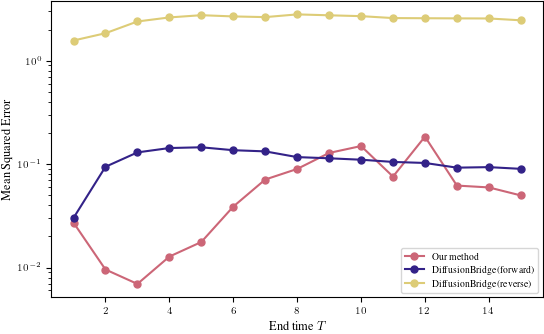

In [7]:

times = np.arange(1, 16)

errors = np.load("ou_errors_reverse_times_1_to_15.npy")    

errors_diffusion_bridge = np.load("/Users/libbybaker/Documents/Python/DiffusionBridge/diffusion_bridge_errors_forward_times_1_to_15.npy")
errors_diffusion_bridge_reverse = np.load("/Users/libbybaker/Documents/Python/DiffusionBridge/diffusion_bridge_errors_backward_times_1_to_15.npy")

plt.semilogy(times, errors, "o-", label="Our method", markersize=5)
plt.semilogy(times, errors_diffusion_bridge, "o-", label="DiffusionBridge (forward)", markersize=5)
plt.semilogy(times, errors_diffusion_bridge_reverse, "o-", label="DiffusionBridge (reverse)", markersize=5)
# plt.semilogx(ds, forward_errors, "o-", label="Forward")
plt.legend()
# plt.xticks(ds, ds)
plt.xlabel(r"End time $T$")
plt.ylabel("Mean Squared Error")
# plt.ylim((-1, 5))
plt.savefig("time_comparison.pdf")
plt.show()


In [8]:
from tueplots import bundles, axes, cycler, figsizes
from tueplots.constants.color import palettes
import matplotlib.pyplot as plt

bundle = bundles.neurips2023()
plt.rcParams.update(bundle)
axes.lines()
plt.rcParams.update(cycler.cycler(color=palettes.paultol_muted))



Create Subplots for both time and dimension

In [9]:
times = np.arange(1, 16)

errors_t = np.load("ou_errors_reverse_times_1_to_15.npy")    
errors_t_diffusion_bridge = np.load("/Users/libbybaker/Documents/Python/DiffusionBridge/diffusion_bridge_errors_forward_times_1_to_15.npy")
errors_t_diffusion_bridge_reverse = np.load("/Users/libbybaker/Documents/Python/DiffusionBridge/diffusion_bridge_errors_backward_times_1_to_15.npy")


In [12]:

from src.data_generate_sde import sde_ornstein_uhlenbeck, time

ds = np.arange(1, 33)
ts = time.grid(0, 1., 100)

errors_d = np.load("dimensions/ou_errors_reverse_dim_1_to_32.npy")    
errors_d_diffusion_bridge = np.load("/Users/libbybaker/Documents/Python/DiffusionBridge/dims/diffusion_bridge_errors_forward_dims_1_to_32.npy")
errors_d_diffusion_bridge_reverse = np.load("/Users/libbybaker/Documents/Python/DiffusionBridge/dims/diffusion_bridge_errors_backward_dims_1_to_16.npy")


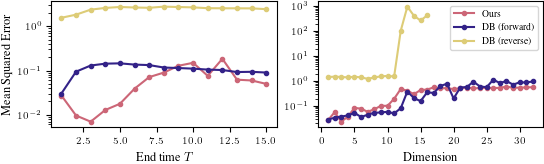

In [19]:
plt.rcParams.update(figsizes.neurips2023(nrows=1, ncols=2))
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=False, sharex=False)

axs[0].semilogy(times, errors_t, "o-", label="Ours", markersize=3)
axs[0].semilogy(times, errors_t_diffusion_bridge, "o-", label="DB (forward)", markersize=3)
axs[0].semilogy(times, errors_t_diffusion_bridge_reverse, "o-", label="DB (reverse)", markersize=3)
axs[0].set_xlabel(r"End time $T$")
axs[0].set_ylabel("Mean Squared Error")

axs[1].semilogy(ds, errors_d, "o-", label="Ours", markersize=3)
axs[1].semilogy(ds, errors_d_diffusion_bridge, "o-", label="DB (forward)", markersize=3)
axs[1].semilogy(ds[:16], errors_d_diffusion_bridge_reverse, "o-", label="DB (reverse)", markersize=3)
axs[1].set_xlabel("Dimension")
axs[1].legend()

plt.savefig("time_and_dims_errors.pdf")
